# AHRS: Euler angle based Unscented Kalman Filter 
- Eulser angle을 기반으로 하는 unscented Kalman filter
- Cholesky decomposition과 matrix dimension에 민감

# Unscented Kalman filter
- 선형화 작업을 하지 않다는 장점이 있지만
- Unscented transformation을 위한 초기 covariance값, system noise 및 measurement noise 값 설정에 매우 민감한 특성이 있다.
- 이러한 이유는 UT를 위한 sigma point는 평균점을 기준으로 covariance에 의해 샘플링 범위가 결정되는데,
- covariance의 특성을 잘 모른다면 잘 못된 Gaussian random distribution을 가정하는 것이 되고 recursive한 동작이 반복될 때 마다
- 오차가 늘어나게 된다.


In [1]:
import numpy as np
from scipy.io import loadmat
from math import sin, cos, tan
import matplotlib.pyplot as plt
from navimath import *

In [2]:
# Dataset selection
# f_number 
# 1: Example data provided by Magdwich
# 2: Real IMU data provided by Witmotion 
# 3: Real IMU data provided by Understanding Kalman filter
f_number = 1


if f_number == 1:
    # Example Data
    ExData1 = loadmat('..\Data\ExampleData.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    time = ExData1['time']
    
    # System model noise covariance
    Q = np.zeros((3,3))
    Q[0, 0] = 0.01     # Roll angle uncertainty
    Q[1, 1] = 0.01     # Pitch angle uncertainty
    Q[2, 2] = 1     # Yaw angle uncertainity    

    # Measurement noise covariance
    R = np.zeros((3,3))
    R[0, 0] = 10      # Accelerometer measurement uncertainty
    R[1, 1] = 10      # Accelerometer measurement uncertainty
    R[2, 2] = 10     # Magnetometer measurement uncertainity    
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = time[1]-time[0]
    totalLen = Accelerometer.shape[0]
    
elif f_number ==2:

    # Example Data
    ExData1 = loadmat('..\Data\WitMotion_IMU_Data.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    Euler_Truth = ExData1['Euler']
        
    # System model noise covariance
    Q = np.zeros((3,3))
    Q[0, 0] = 100     # Roll angle uncertainty
    Q[1, 1] = 100     # Pitch angle uncertainty
    Q[2, 2] = 1000     # Yaw angle uncertainity

    # Measurement noise covariance
    R = np.zeros((3,3))
    R[0, 0] = 10      # Accelerometer measurement uncertainty
    R[1, 1] = 10      # Accelerometer measurement uncertainty
    R[2, 2] = 10     # Magnetometer measurement uncertainity
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = 1
    totalLen = Accelerometer.shape[0]
    
else:
    ArsAccel = loadmat('..\Data\ArsAccel.mat')
    ArsGyro = loadmat('..\Data\ArsGyro.mat')
    
    Gyroscope = np.zeros((41500, 3))
    Accelerometer = np.zeros((41500, 3))
    
    Gyroscope[:,0] = ArsGyro['wx'][:,0]
    Gyroscope[:,1] = ArsGyro['wy'][:,0]
    Gyroscope[:,2] = ArsGyro['wz'][:,0]
    
    Accelerometer[:,0] = ArsAccel['fx'][:,0]
    Accelerometer[:,1] = ArsAccel['fy'][:,0]
    Accelerometer[:,2] = ArsAccel['fz'][:,0]    
    
    Q = np.array([[0.0001, 0, 0],
              [0, 0.0001, 0],
              [0, 0, 1]])
    R = 10 * np.eye(3)
    
    mu0 = np.zeros((3))
    sigma0 = np.eye((3))
    
    Ts = 0.01
    totalLen = 41500

## 지원함수

In [3]:
# System function
def fX(X_, Gyroscope, Ts):
    
    
    fX_i = np.zeros((X_.shape[0],X_.shape[1]))    # return value
    
    # Gyroscope measurement
    p, q, r = Gyroscope
    
    phi = X_[:,0]
    theta = X_[:,1]
    psi = X_[:,2]
        
    phi_ = (p + q*(np.sin(phi) * np.tan(theta)) + r*(np.cos(phi) * np.tan(theta)))*Ts
    theta_ =  (q*(np.cos(phi)) + r*(-np.sin(phi)))*Ts
    psi_ = (q*(np.sin(phi) * 1/np.cos(theta)) + r*(np.cos(phi) * 1/np.cos(theta)))*Ts

    fX_i[:, 0] = X_[:,0] + phi_
    fX_i[:, 1] = X_[:,1] + theta_
    fX_i[:, 2] = X_[:,2] + psi_    
    
    return fX_i 

def hX(X_):    
    return X_



# Genrate sigma point
def sigma_point(mu_, sigma_, n_sigma_, lambda_):
    
    n_x_ = len(mu_)
    
    X_ = np.zeros((n_sigma, n_x_))    # mean state variable: vector
    w_m_ = np.zeros((n_sigma))       # weight for mean: scalar 
    w_c_ = np.zeros((n_sigma))       # weight for covariance: scalar
    
    U = np.transpose(np.linalg.cholesky((n_x + lambda_)*sigma_)) # Cholesky decomposition
    
    for i in range(n_x + 1):        
        if i == 0:            
            X_ [i, :] = mu_
            w_m_[i] = lambda_ / (n_x + lambda_)
            w_c_[i] = lambda_ / (n_x + lambda_) + 4            
        else:
            X_[i, :] = mu_ + U[i-1,:]
            X_[i+n_x, :] = mu_ - U[i-1,:]
            
            w_m_[i] = 1.0/(2.0*(n_x + lambda_))
            w_m_[i+n_x] = w_m_[i]
            
            w_c_[i] = w_m_[i]   
            w_c_[i+n_x] = w_c_[i]
    
    return X_, w_m_, w_c_


# Calculate weighted mean
# w_: weight for mean
# Xi_: sigma points
def mean(w_, Xi_):    
    
    w_ = np.reshape(w_, (-1,1))
    
    mu_ = np.sum((w_ * Xi_), axis = 0)    
    
    return mu_

# Calculatd covariance for sigma points
# w_sigma: covariance for mean
# f_X: Output value of system function with sigma points
# mu: mean
def covariance(w_, fX_, mu_):    
    
    w_ = np.reshape(w_, (-1,1))
    mu_ = np.reshape(mu_, (1,-1))
    
    sigma_ = np.matmul(np.transpose(fX_ - mu_),w_ * (fX_ - mu_))
    
    return sigma_  

def covariance_xz(fX_, mu_x_, hX_, mu_z_, w_):      
    
    w_ = np.reshape(w_, (-1,1))
    mu_x_ = np.reshape(mu_x_,(1,-1))
    mu_z_ = np.reshape(mu_z_,(1,-1))
    
    sigma_xz_ = np.matmul(np.transpose(fX_ - mu_x_),(w_*(hX_ - mu_z_)))
          
    return sigma_xz_

In [4]:
############################################################################################################
# Unscented Kalman Filter Parameters and variables

n_x = 3                                  # number of states
n_sigma = 2 * n_x + 1                    # number of 2n+1 sgma point
alpha = 1.0                              # alpha
beta  = 2.0                              # beta
k = 3 - n_x                              # Kappa
lambda_ = alpha ** 2 *(n_x + k) - n_x    # lambda

# sigma point
# X: sigma point
# w_m: weight sigma point
# w_c: weight covariance
X = np.zeros((n_sigma, n_x))
w_m = np.zeros((n_sigma, n_x))
w_c = np.zeros((n_sigma, n_x))

# Unscented Kalman Filter Parameters and variables
############################################################################################################


# State variable for mean
mu = np.zeros((n_x))                   # state mean variable and initialization
mu_hist = np.zeros((totalLen, n_x))    # state mean history initialization

# System covariance
sigma = np.eye((n_x))                   # sigma initialization
sigma_hist = np.zeros((totalLen, n_x))  # sigma history initialization

# Mean for only prediction step
mu_x = np.zeros((n_x))

# Covariance for only prediction
sigma_x = np.eye((n_x))
sigma_x_hist = np.zeros((totalLen, n_x))  # sigma history initialization

# Measurement variable for mean
mu_z = np.zeros((n_x))
sigma_z = np.eye((n_x))


# measurement update에 사용되는 measurement를 위한 변수
z_hist = np.zeros((totalLen, 3))        # measurement history initialization
z_diff_hist=np.zeros((totalLen, 3))     # measurement history initialization


# Sensor fusion 결과 확인을 위한 보조 변수들 
angle = np.zeros((n_x))
angle_hist = np.zeros((totalLen, 3))


# measurement update True ==> EKF prediction + measurement update
# measurement update False ==> EKF prediction only
measurement_update = True

for i in range(totalLen):       
    
    if i == 0:
        mu = mu0
        mu_x = mu0
        
        sigma = sigma0
        sigma_x = sigma0
    
        angle = mu0
    
    # calculate sigma points
    # num. of sigma points = 2*3 + 1 = 7
    # 7 sigmal points per mu    
    X, w_m, w_c = sigma_point(mu, sigma, n_sigma, lambda_)    
    fX_i = fX(X, Gyroscope[i,:,], Ts) 
        
    mu_x = mean(w_m, fX_i)   
    sigma_x = covariance(w_c, fX_i, mu_x) + Q
        
    mu = mu_x
    sigma = sigma_x
    
    ###########################################################################################
    # 추가적인 기능 확인을 위한 코드    
    # Attitude estimation by only accumulating gyroscope angular rate
    angle = Euler_accum(angle, Gyroscope[i,:], Ts)
    angle_hist[i,:] = angle
    
    # Measurement update를 위한 Accelerometer와 Magnetometer를 사용한 Attitude
    if f_number == 3:
        z = attitudemeasure(mu, 1, Accelerometer[i,:])
    else:
        z = attitudemeasure(mu, 2, Accelerometer[i,:], Magnetometer[i,:])   
        
    z_hist[i,:] = z
    
    # 추가적인 기능확인을 위한 코드
    ##########################################################################################    
    
    if measurement_update == True:
        
        # Measurement equation
        hX_i = hX(X)
        
        # Meand and covariance
        mu_z = mean(w_m, hX_i)            
        sigma_z = covariance(w_c, hX_i, mu_z) + R
          
        sigma_xz = covariance_xz(fX_i,mu_x, hX_i, mu_z, w_c)  
        
        # Kalman gain
        K = np.matmul(sigma_xz, np.linalg.inv(sigma_z))
        Kz = np.transpose(np.matmul(K,np.transpose(z - mu_z)))
        
        # Measurement update
        mu = mu + Kz        
        sigma = sigma_x - np.matmul(np.matmul(K, sigma_z), np.transpose(K))
        
        z_hist[i,:] = z 
        z_diff_hist[i,:] = z - mu_z
    
    # State estimation save
    mu_hist[i,:] = mu
       
    # Covarinace save
    sigma_hist[i, 0] = sigma[0,0]
    sigma_hist[i, 1] = sigma[1,1]
    sigma_hist[i, 2] = sigma[2,2]    
    
    sigma_x_hist[i, 0] = sigma_x[0,0]
    sigma_x_hist[i, 1] = sigma_x[1,1]
    sigma_x_hist[i, 2] = sigma_x[2,2]
    
    angle_hist[i,:] = angle    

Text(0.5, 1.0, 'Attitude by accelerometer and magnetometer')

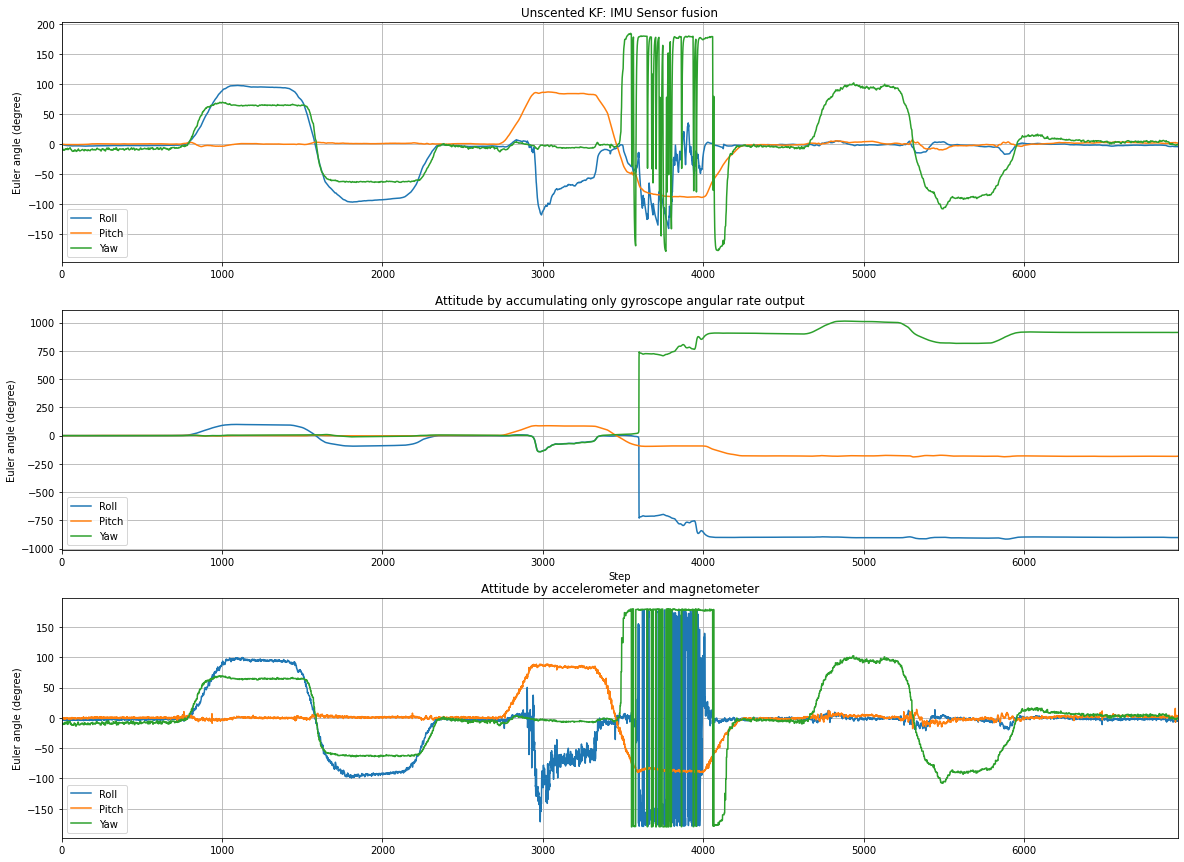

In [5]:
if measurement_update == True:
    title='Unscented KF: IMU Sensor fusion'
else:
    title='Unscented KF: Prediction only'

plt.figure(figsize=(20,15))
plt.subplot(3,1,1)    
if f_number == 3:
    # Result plotting    
    plt.plot(np.rad2deg(mu_hist[:,0:2]))
    plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
    plt.grid()    
    plt.ylabel('Euler angle (degree)')
    plt.xlim([0,totalLen])
    plt.title(title)
else:
    # Result plotting    
    plt.plot(np.rad2deg(mu_hist))
    plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
    plt.grid()    
    plt.ylabel('Euler angle (degree)')
    plt.xlim([0,totalLen])
    plt.title(title)

# Result plotting
plt.subplot(3,1,2)    
plt.plot(np.rad2deg(angle_hist))
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accumulating only gyroscope angular rate output')

# Measurement updat를 위한 accelerometer와 magnatometer의 자세
plt.subplot(3,1,3)    
plt.plot(np.rad2deg(z_hist))
#plt.plot(z_hist)
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accelerometer and magnetometer')

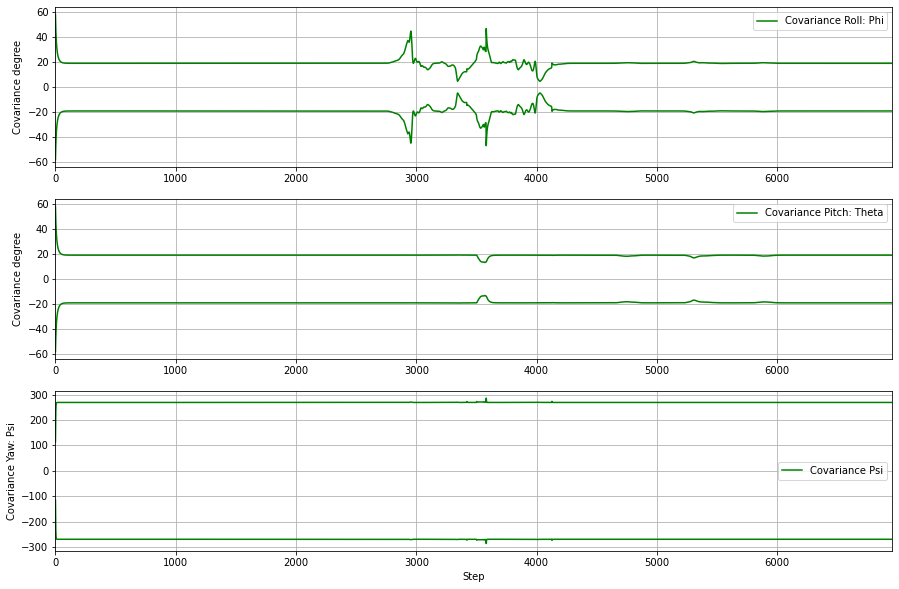

In [6]:
# Covariance plotting
# Result plotting
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(np.rad2deg(sigma_x_hist[:,0]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,0]), 'g')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Roll: Phi'])

# Result plotting
plt.subplot(3,1,2)
plt.plot(np.rad2deg(sigma_x_hist[:,1]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,1]), 'g')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Pitch: Theta'])

# Result plotting
plt.subplot(3,1,3)
plt.plot(np.rad2deg(sigma_x_hist[:,2]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,2]), 'g')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance Yaw: Psi')
plt.xlim([0,totalLen])
plt.legend(['Covariance Psi'])

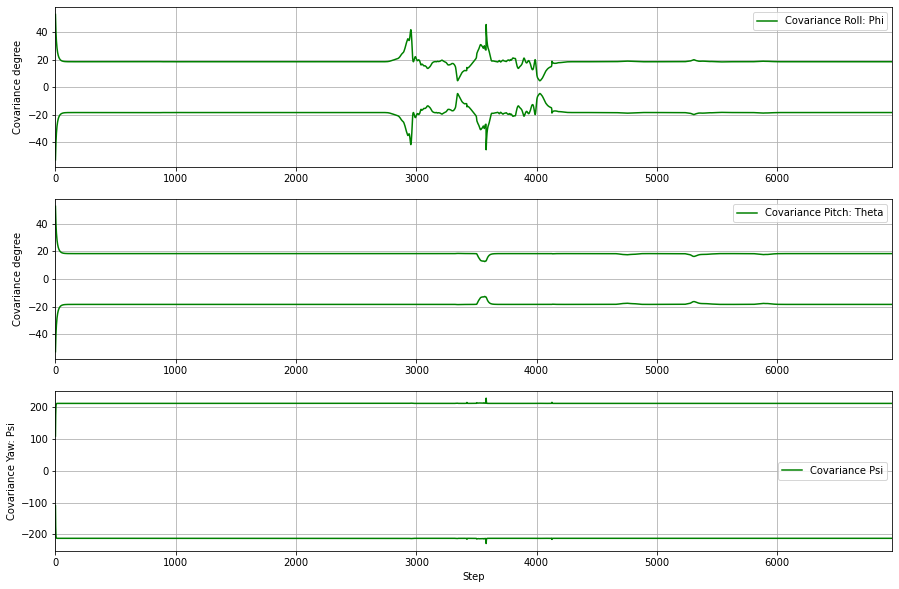

In [7]:
# Covariance plotting
# Result plotting
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(np.rad2deg(sigma_hist[:,0]), 'g')
plt.plot(-np.rad2deg(sigma_hist[:,0]), 'g')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Roll: Phi'])

# Result plotting
plt.subplot(3,1,2)
plt.plot(np.rad2deg(sigma_hist[:,1]), 'g')
plt.plot(-np.rad2deg(sigma_hist[:,1]), 'g')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Pitch: Theta'])

# Result plotting
plt.subplot(3,1,3)
plt.plot(np.rad2deg(sigma_hist[:,2]), 'g')
plt.plot(-np.rad2deg(sigma_hist[:,2]), 'g')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance Yaw: Psi')
plt.xlim([0,totalLen])
plt.legend(['Covariance Psi'])